## Notes on features to choose:

### From Kaggle:
#### Extensive Sberbank Exploratory Analysis:
**source:** https://www.kaggle.com/captcalculator/a-very-extensive-sberbank-exploratory-analysis
* 37 observations where life_sq is greater than full_sq.
* A vast majority of the apartments have three rooms or less.
* look to see how life sq ~ price changes based on sub-area or distance to kremlin
* Home price does seem to increase with population density.
* There does not appear to be a relationship between the mean home price in a district and the district’s share of working age population.
* Surprisingly, there is little to no correlation between price and the school variables. The school variables however are highly correlated with each other, indicating that we would not want to use all of them in a linear regression model due to multicollinearity.
* homes with >3 top 20 universities show signs of correlation, but only one house fits that description.
* raions that have a top 25 cultural object have a median home sale price that is higher by 1.2 million (using this feature as a factor)
* strong positive correlation between sport_objects_raion and price_doc

#### Simple Exploration Notebook - Sberbank
**source:** https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-sberbank

* overall increasing trend in price as floor_num increases. A sudden increase in the house price is also observed at floor 18.
* Individual houses seems to be costlier, check price of 0 floor houses.

#### Map visualizations with external shapefile
**source:** https://www.kaggle.com/jtremoureux/map-visualizations-with-external-shapefile/notebook



### Import Libraries & Data

In [35]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="ticks", palette="muted", color_codes=True)

In [36]:
# load dataset

df = pd.read_csv("./cleaned_outliers_removed_2017-05-29.csv", parse_dates=['timestamp'], index_col=False, low_memory=False)

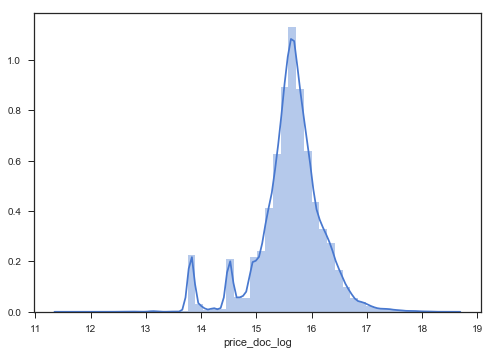

In [37]:
import seaborn as sns


# sns.distplot(df['build_year'].dropna())
# sns.distplot(df['price_doc'].dropna())
sns.distplot(df['price_doc_log'].dropna())
# df[['build_year','state']].dropna().corr().plot()

In [40]:
df['age_log'] = np.log1p(df['age'])

In [7]:
# features = ['timestamp', 'state', 'age', 'floor', 'full_sqrt', 'area_km', 'density','month','year','day',
#                 'rel_floor', 'material', 'num_room', 'work_share','kitch_sq', 'product_type', 'sub_area', 'indust_part', 'sport_objects_raion', 'oil_chemistry_raion', 'metro_min_avto',
#                'green_zone_km', 'industrial_km', 'kremlin_km', 'radiation_km', 'ts_km', 'fitness_km',
#                'stadium_km', 'park_km', 'price_doc_log']

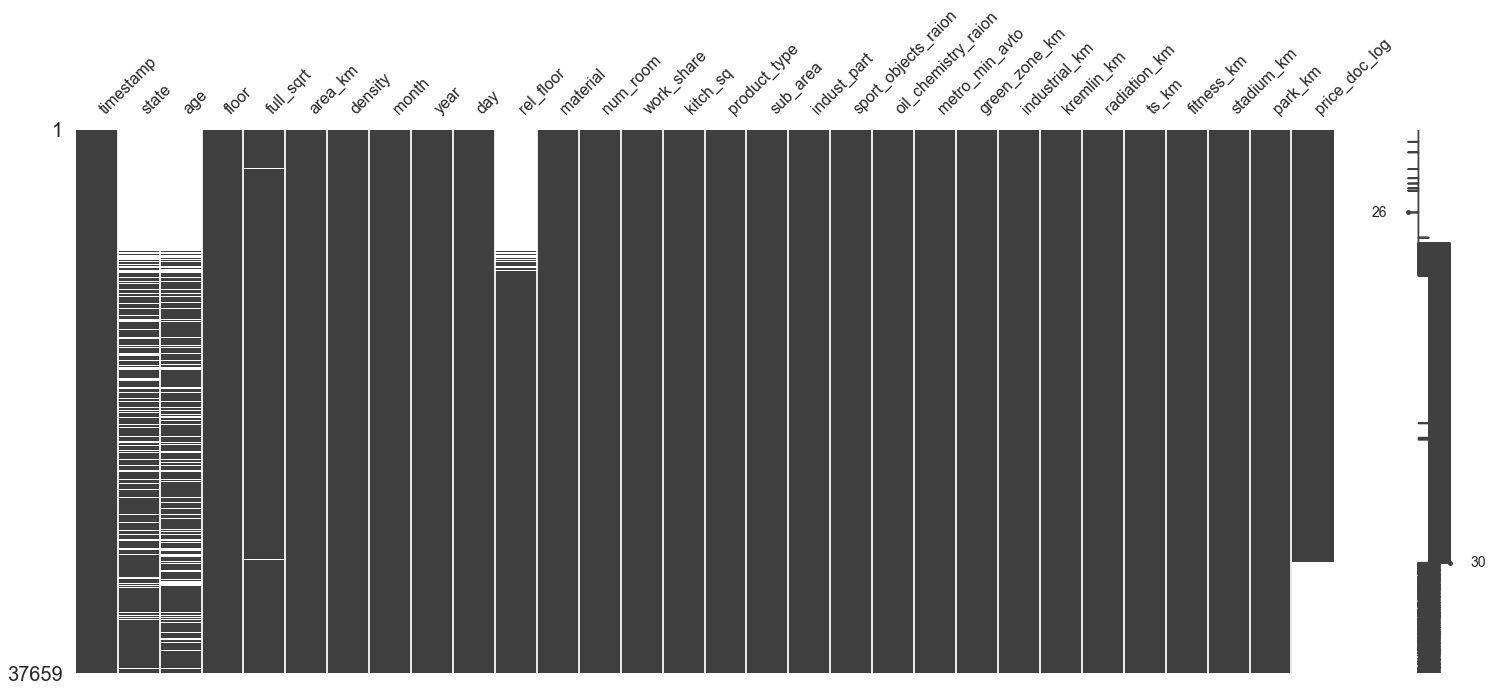

In [8]:
import missingno as msno
# filtered_data = msno.nullity_filter(df[features], filter='bottom', n=50, p=0.99) # or filter='top'

msno.missingno.matrix(df[features])

In [9]:
for feature in features:
    if np.sum(df[feature].isnull()) > 0:
        print feature,np.sum(df[feature].isnull())

state 13934
age 15761
full_sqrt 49
rel_floor 9303
price_doc_log 7662


## Build Year

Build year has about 1/3 of it's data missing. With it's strong feature importance in a variety of different models, we decided to try and find a way to regress against build_year to predict the missing values. 


In [10]:
df['build_year'].describe()
# df['state'].describe()

count    21898.000000
mean      1986.150562
std         21.187216
min       1860.000000
25%       1969.000000
50%       1982.000000
75%       2007.000000
max       2019.000000
Name: build_year, dtype: float64

#### Convert categorical featuers to factors

In [41]:
# Considering the predictors having high or some correlation with price_doc (from EDA)

vars_subset = ['age_log','year','month','floor', 'max_floor', 'state', 'indust_part',
       'school_education_centers_raion', '16_29_female',
       'build_count_monolith', 'metro_km_walk', 'kindergarten_km',
       'school_km', 'green_zone_km', 'public_transport_station_min_walk',
       'ttk_km', 'ID_big_road2', 'ID_bus_terminal', 'oil_chemistry_km',
       'fitness_km', 'swim_pool_km', 'public_healthcare_km',
       'workplaces_km', 'mosque_km', 'theater_km', 'catering_km',
       'green_part_500', 'office_sqm_500', 'cafe_count_500_price_4000',
       'cafe_count_500_price_high', 'church_count_500',
       'leisure_count_500', 'cafe_count_1000_price_high', 'prom_part_1500',
       'cafe_sum_1500_max_price_avg', 'big_church_count_1500',
       'mosque_count_1500', 'cafe_count_2000',
       'cafe_sum_2000_min_price_avg', 'big_church_count_2000',
       'prom_part_3000', 'cafe_count_3000_price_2500', 'sport_count_3000',
       'cafe_count_5000_price_2500', 'cafe_count_5000_price_high',
       'mosque_count_5000', 'rts', 'micex_rgbi_tr', 'cpi', 'product_type',
       'sub_area', 'big_road1_1line', 'railroad_1line']

df_subset = df[vars_subset]

**Split the data into a train/test set, with the test set being the observations where age are missing.**

In [43]:
y_train = df_subset.loc[df_subset['age_log'].notnull(), 'age_log']
X_train = df_subset.loc[df_subset['age_log'].notnull(), df_subset.columns != 'age_log']
X_test = df_subset.loc[df_subset['age_log'].isnull(), df_subset.columns != 'age_log']

print y_train.shape, X_train.shape, X_test.shape

(21898,) (21898, 52) (15761, 52)


In [45]:
import xgboost as xgb

xgb_params = {
    'eta': 0.05,
    'max_depth': 10,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns)
dtest = xgb.DMatrix(X_test, feature_names=X_test.columns)

# cv_result = xgb.cv(xgb_params, dtrain, num_boost_round=500, early_stopping_rounds=50,
#    verbose_eval=True, show_stdv=False)
# cv_result[['train-rmse-mean', 'test-rmse-mean']].plot()
# num_boost_rounds = len(cv_result)

In [ ]:
num_boost_round = 220

model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_round)

In [46]:
y_pred = model.predict(dtest)

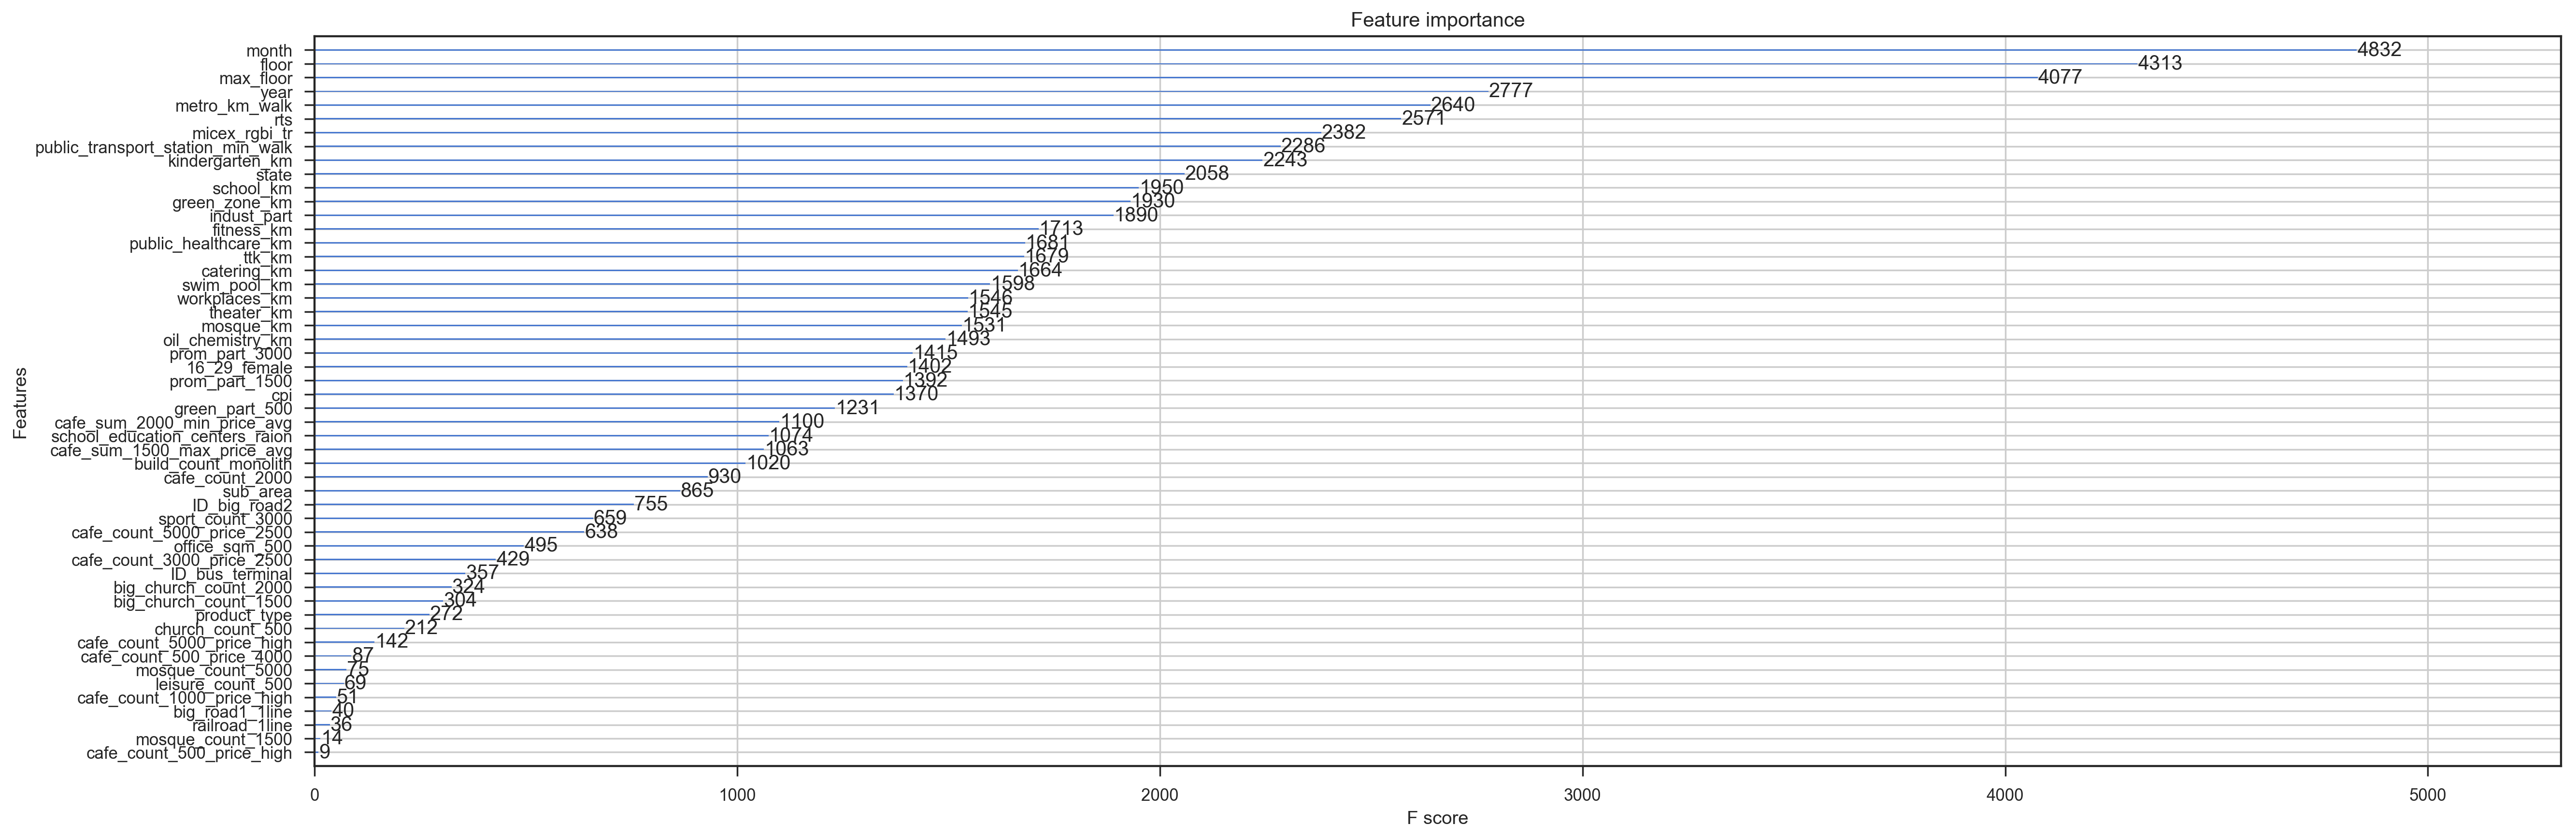

In [47]:
# plot the important features #
fig, ax = plt.subplots(figsize=(24,8), dpi=250)
xgb.plot_importance(model, height=.1, ax=ax)
plt.show()

In [48]:
np.sum(y_pred < 0), np.sum(y_pred > 0)

(2813, 12948)

### Impute predicted build_year values

In [51]:
df.loc[df['age'].isnull(), df.columns == 'age'] = y_pred.round()

In [52]:
np.sum(df['age'].isnull())

0

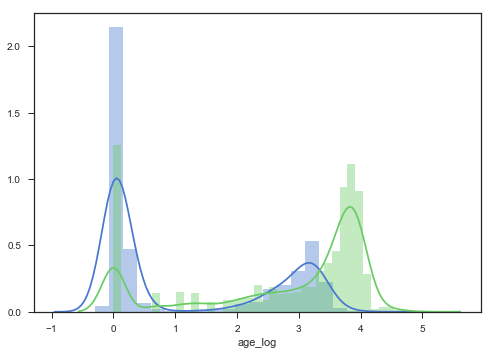

In [54]:
import seaborn as sns

sns.distplot(y_pred)
sns.distplot(y_train)

In [55]:
df.loc[df['age'] < 0] = 0

In [56]:
df['timestamp']

0       2011-08-20
1       2011-08-23
2       2011-08-27
3       2011-09-01
4       2011-09-05
5       2011-09-06
6       2011-09-08
7       2011-09-09
8       2011-09-10
9       2011-09-13
10      2011-09-16
11      2011-09-16
12      2011-09-17
13      2011-09-19
14      2011-09-19
15      2011-09-20
16      2011-09-20
17      2011-09-20
18      2011-09-22
19      2011-09-22
20      2011-09-22
21      2011-09-22
22      2011-09-23
23      2011-09-23
24      2011-09-23
25      2011-09-24
26      2011-09-26
27      2011-09-26
28      2011-09-26
29      2011-09-27
           ...    
37629   2016-05-20
37630   2016-05-20
37631   2016-05-20
37632   2016-05-20
37633   2016-05-21
37634   2016-05-21
37635   2016-05-21
37636   2016-05-21
37637   2016-05-23
37638   2016-05-23
37639   2016-05-23
37640   2016-05-23
37641   2016-05-23
37642   2016-05-23
37643   2016-05-23
37644   2016-05-23
37645   2016-05-23
37646   2016-05-24
37647   2016-05-24
37648   2016-05-24
37649   2016-05-24
37650   2016

No N/A values remaining for build_year!

### Export to new data files

In [57]:
from datetime import datetime

df.loc[df['price_doc'].notnull(), :].to_csv('./train_df_build_year_{0}.csv'.format(datetime.date(datetime.now())), index=False)
df.loc[df['price_doc'].isnull(), :].to_csv('./test_df_build_year_{0}.csv'.format(datetime.date(datetime.now())), index=False)
df.to_csv('./merged_w_build_year_{0}.csv'.format(datetime.date(datetime.now())), index=False)